In [468]:
import os
import h5py
from scipy.io import loadmat
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from itertools import combinations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import StrMethodFormatter
from IPython.display import HTML
from preproc import *
import pickle

In [193]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181101"

# Save directory for figures and data files
figsave_dir = f'figures/{day_dir}/pcaview'

### Preprocessing of rplparallel, spiketrain, vmpv, raycast data

In [194]:
# Get list of cells under the day directory
os.system(f"sh ~/Documents/neural_decoding/Hippocampus_Decoding/get_cells.sh {day_dir}")
cell_list = list()
with open("cell_list.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())
os.system("rm cell_list.txt")

# Load data from rplparallel.mat object, extract trial markers, time stamps and session start timestamp
rp_file = h5py.File(prefix + day_dir + "/session01/rplparallel.mat")
rp = rp_file.get('rp').get('data')
trial_markers = np.array(rp.get('markers'))
trial_timestamps = np.round(np.array(rp.get('timeStamps')), 3)
session_start_time = np.round(np.array(rp.get('session_start_sec'))[0,0], 3)
rp_file.close()

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
cell_labels = list()
for cell_dir in cell_list:
    try:
        spk_file = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    except NotImplementedError:
        spk_file = h5py.File(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    except FileNotFoundError:
        continue
    spk = np.array(spk_file.get('timestamps')).flatten() # spike timestamps is loaded in as a column vector
    spk /= 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)
    if isinstance(spk_file, h5py.File):
        spk_file.close()
    
    cell_name = cell_dir.split('/')
    array, channel, cell = cell_name[0][6:], cell_name[1][7:], cell_name[2][5:]
    if channel[0] == '0':
        channel = channel[1:]
    cell_labels.append(f'a{array}/ch{channel}/c{cell}')

# Load data from vmpv.mat object, extract session end timestamp
pv_file = h5py.File(prefix + day_dir + "/session01/1vmpv.mat")
pv = pv_file.get('pv').get('data')
session_end_time = np.round(np.array(pv.get('rplmaxtime'))[0,0], 3)
pv_file.close()

In [195]:
# Define important constants
num_cells = len(cell_labels)
num_goals = 6
time_res = 0.001
tbin_size = 0.1

In [196]:
# Get trial outcomes from trial markers
# 0 for unsuccessful trials, 1 for successful trials
trial_outcomes = 4 - trial_markers[2,:] // 10
trial_outcomes = trial_outcomes.astype(int)

# Get poster numbers from trial markers, cue phase time intervals
trial_markers = trial_markers[0,:] % 10
trial_markers = trial_markers.astype(int)
cue_intervals = trial_timestamps[0:2,:].T

# Get durations of each navigation phase
nav_intervals = trial_timestamps[1:,:].T
nav_durations = nav_intervals[:,1] - nav_intervals[:,0]

# Generate time intervals for each trial
trial_intervals = np.empty_like(cue_intervals)
trial_intervals[:,0] = cue_intervals[:,1]
trial_intervals[:-1,1] = cue_intervals[1:,0]
trial_intervals[-1,1] = session_end_time

# Further differentiate trial markers into trial trajectories (start poster, end poster)
trial_trajectories = np.zeros((trial_markers.shape[0], 2))
trial_trajectories[:,1] = trial_markers
trial_trajectories[1:,0] = trial_markers[:-1]

In [197]:
# Filter out trials that are too long (> 25 seconds) or have repeated goal from previous trial
good_trials = np.ones(trial_markers.shape, dtype=np.int8)
max_dur = 25  # maximum duration of trials (in seconds) to filter out
prev_goal = 0
for num, dur in enumerate(nav_durations):
    curr_goal = trial_markers[num]
    if dur > max_dur or curr_goal == prev_goal:
        good_trials[num] = 0
    prev_goal = curr_goal
trial_filt = np.where(good_trials == 1)

trial_outcomes = trial_outcomes[trial_filt]
trial_markers = trial_markers[trial_filt]
cue_intervals = cue_intervals[trial_filt]
nav_intervals = nav_intervals[trial_filt]
nav_durations = nav_durations[trial_filt]
trial_intervals = trial_intervals[trial_filt]
trial_trajectories = trial_trajectories[trial_filt]

Cue phase data

In [198]:
# Preallocate list of arrays for spike counts per time bin in cue phase
# Then slot spikes into cue phase intervals, using time bin resolution specified by tbin_size
timebins_cue, spikecounts_cue = list(), list()
for trial in cue_intervals:
    st_time, ed_time = trial
    ed_time = st_time + 10 * tbin_size
    timebins_cue_trial = np.hstack([np.arange(st_time, ed_time, tbin_size).reshape(-1,1), np.arange(st_time, ed_time, tbin_size).reshape(-1,1) + tbin_size])
    timebins_cue.append(timebins_cue_trial)
    spikecounts_cue.append(np.array(spike_counts_per_observation(timebins_cue_trial, spike_times)))

# Convert spike counts to average spike rates across duration of cue phase
spikerates_cue = [trial/tbin_size for trial in spikecounts_cue]

# Filter out trials with nans in cue spike rates
goals_cue = trial_markers.copy()
trajectories_cue = trial_trajectories.copy()

### Cue phase, goal response distances

In [199]:
def group_by_goal(timeseries: np.array, goals: np.array) -> list:
    # num_goals = 6
    grouped = [list() for _ in range(num_goals)]
    for idx, goal in enumerate(goals):
        goal = int(goal - 1)
        grouped[goal].append(timeseries[idx])
    return grouped

def group_by_trajectory(timeseries: np.array, trajectories: np.array) -> list:
    # num_goals = 6
    grouped = {(i+1, j+1): list() for j in range(num_goals) for i in range(num_goals) if i != j}
    for idx, traj in enumerate(trajectories):
        goal1, goal2 = int(traj[0]), int(traj[1])
        if goal1 == 0:
            continue
        grouped[(goal1, goal2)].append(timeseries[idx])
    return grouped

In [200]:
# Apply PCA to cue phase spike rates for subsequent visualization
# For scree plot/cumulative explained variance
pca = PCA()
pca.fit(np.vstack(spikerates_cue))
pca_numcomps, pca_expvar = pca.n_components_, pca.explained_variance_ratio_

# For actual fitting to data, using 3 PCs
pca = PCA(n_components=3)
pcspikerates_cue = pca.fit_transform(np.vstack(spikerates_cue))
pcspikerates_cue = np.array([pcspikerates_cue[10*i:10*(i+1),:] for i in range(pcspikerates_cue.shape[0]//10)])

# Group cue phase responses according to goal
pcspikerates_cue_per_goal = group_by_goal(pcspikerates_cue, goals_cue)
for i, goal in enumerate(pcspikerates_cue_per_goal):
    pcspikerates_cue_per_goal[i] = np.array(goal)

# Group cue phase responses according to trajectory, then group by same start goal and same end goal
spikerates_cue_per_traj = group_by_trajectory(spikerates_cue, trajectories_cue)
spikerates_cue_start_goals, spikerates_cue_end_goals = [list() for _ in range(num_goals)], [list() for _ in range(num_goals)]
start_goals_labels, end_goals_labels = [list() for _ in range(num_goals)], [list() for _ in range(num_goals)]
for traj, responses in spikerates_cue_per_traj.items():
    start_goal, end_goal = traj[0] - 1, traj[1] - 1
    spikerates_cue_start_goals[start_goal].extend(responses)
    start_goals_labels[start_goal].extend(len(responses) * [end_goal + 1])
    spikerates_cue_end_goals[end_goal].extend(responses)
    end_goals_labels[end_goal].extend(len(responses) * [start_goal + 1])

# Fit PCA within each group of same starting/same ending goal
pcspikerates_cue_start_goals, pcspikerates_cue_end_goals = list(), list()
for i in range(num_goals):
    pc_start_goals = pca.fit_transform(np.vstack(spikerates_cue_start_goals[i]))
    pc_end_goals = pca.fit_transform(np.vstack(spikerates_cue_end_goals[i]))
    pcspikerates_cue_start_goals.append(np.array([pc_start_goals[10*j:10*(j+1),:] for j in range(pc_start_goals.shape[0]//10)]))
    pcspikerates_cue_end_goals.append(np.array([pc_end_goals[10*j:10*(j+1),:] for j in range(pc_end_goals.shape[0]//10)]))

# Regroup into trajectories for plotting
pcspikerates_cue_per_traj = [[np.empty((0, 10, 3)) for i in range(num_goals)] for j in range(num_goals)]
for i in range(num_goals):
    for j, data in enumerate(pcspikerates_cue_start_goals[i]):
        k = start_goals_labels[i][j] - 1
        pcspikerates_cue_per_traj[i][k] = np.concatenate([pcspikerates_cue_per_traj[i][k], data.reshape(-1, 10, 3)], axis=0)

In [201]:
sum(map(lambda x: sum(map(lambda y: y.shape[0], x)), pcspikerates_cue_per_traj))

395

In [202]:
# Plot the average response per trajectory
pcspikerates_cue_per_traj_avg = [[np.empty((0, 10, 3)) for i in range(num_goals)] for j in range(num_goals)]
for i in range(num_goals):
    for j, data in enumerate(pcspikerates_cue_per_traj[i]):
        if i == j:
            continue
        pcspikerates_cue_per_traj_avg[i][j] = np.concatenate([pcspikerates_cue_per_traj_avg[i][j], np.mean(data, axis=0).reshape(1, 10, 3)], axis=0)

# Subtract the first frame from all subsequent frames to get the displacement from start
pcspikerates_cue_per_traj_ref = [[pcspikerates_cue_per_traj_avg[i][j][:,0,:] for j in range(num_goals)] for i in range(num_goals)]
pcspikerates_cue_per_traj_start = [[pcspikerates_cue_per_traj_avg[i][j].copy() for j in range(num_goals)] for i in range(num_goals)]
for i in range(num_goals):
    for j in range(num_goals):
        if i == j:
            continue
        pcspikerates_cue_per_traj_start[i][j] -= pcspikerates_cue_per_traj_ref[i][j]

# Subtract the last frame from all previous frames to get the displacement from end
pcspikerates_cue_per_traj_ref = [[pcspikerates_cue_per_traj_avg[i][j][:,-1,:] for j in range(num_goals)] for i in range(num_goals)]
pcspikerates_cue_per_traj_end = [[pcspikerates_cue_per_traj_avg[i][j].copy() for j in range(num_goals)] for i in range(num_goals)]
for i in range(num_goals):
    for j in range(num_goals):
        if i == j:
            continue
        pcspikerates_cue_per_traj_end[i][j] -= pcspikerates_cue_per_traj_ref[i][j]

Plots for response PCA

Text(0, 0.5, '% Variance Explained')

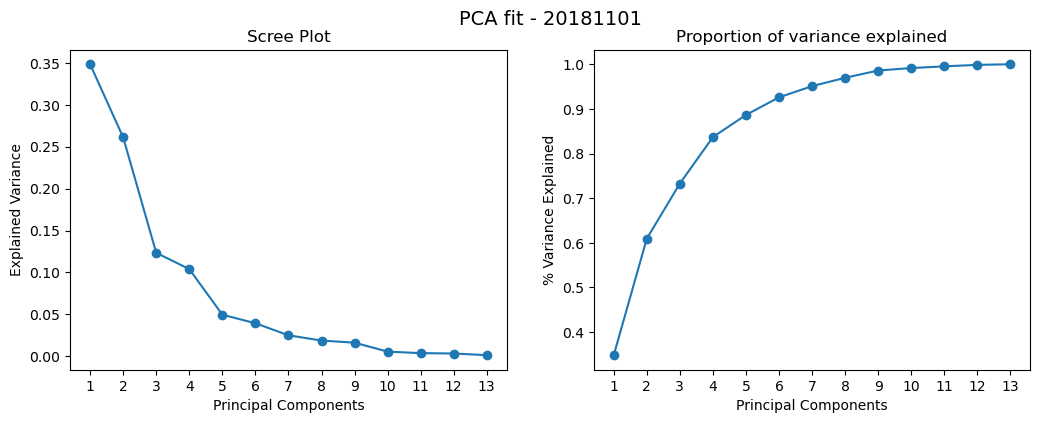

In [203]:
# PCA scree plot and cumulative explained variance for cue spike rates
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.1)
plt.suptitle(f'PCA fit - {day_dir}', fontsize=14, y=1)

axes[0].set_title('Scree Plot')
axes[0].plot(np.arange(pca_numcomps), pca_expvar, 'o-')
axes[0].set_xticks(np.arange(pca_numcomps), labels=np.arange(1, pca_numcomps+1))
axes[0].set_xlabel('Principal Components')
axes[0].set_ylabel('Explained Variance')

axes[1].set_title('Proportion of variance explained')
axes[1].plot(np.arange(pca_numcomps), np.cumsum(pca_expvar), 'o-')
axes[1].set_xticks(np.arange(pca_numcomps), labels=np.arange(1, pca_numcomps+1))
axes[1].set_xlabel('Principal Components')
axes[1].set_ylabel('% Variance Explained')

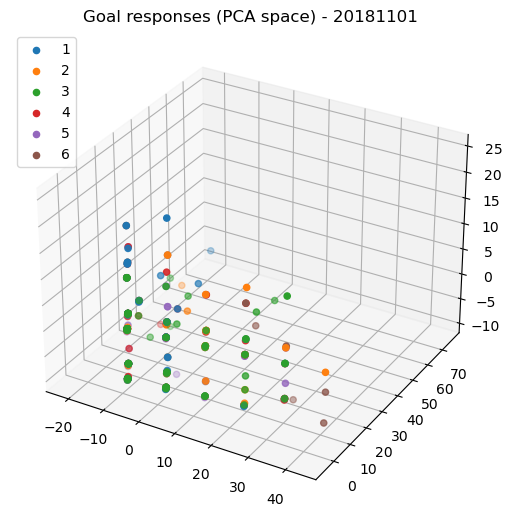

In [204]:
# Plot in PCA space for cue responses between different goals
fig = plt.figure()
ax = fig.gca()
ax.axis('off')
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
plt.title(f'Goal responses (PCA space) - {day_dir}')

# Choose which frame to plot
frame_num = 1
for i in range(num_goals):
    plot_data = pcspikerates_cue_per_goal[i]
    ax.scatter(plot_data[:,frame_num,0], plot_data[:,frame_num,1], plot_data[:,frame_num,2], color=f'C{i}', label=i+1)
plt.legend(loc='upper left')

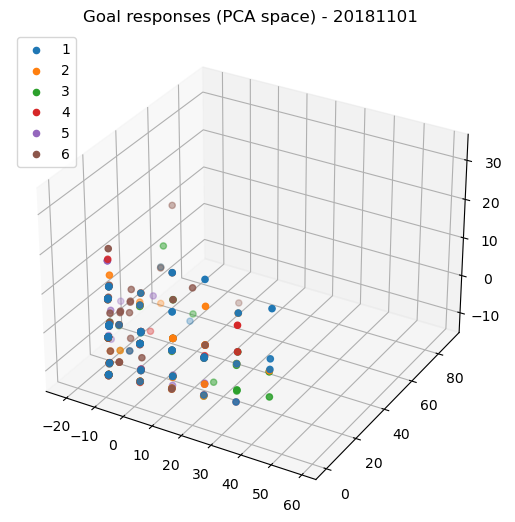

In [205]:
# Plot in PCA space for cue responses between different goals
fig = plt.figure()
ax = fig.gca()
ax.axis('off')
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
plt.title(f'Goal responses (PCA space) - {day_dir}')
sc_plots = list()
ax_lims = [[0, 0] for _ in range(3)]
for i in range(num_goals):
    plot_data = pcspikerates_cue_per_goal[i]
    sc = ax.scatter(plot_data[:,0,0], plot_data[:,0,1], plot_data[:,0,2], color=f'C{i}', label=i+1)
    sc_plots.append(sc)
    ax_lims[0][0] = min(ax_lims[0][0], np.min(plot_data[:,:,0], axis=None))
    ax_lims[0][1] = max(ax_lims[0][1], np.max(plot_data[:,:,0], axis=None))
    ax_lims[1][0] = min(ax_lims[1][0], np.min(plot_data[:,:,1], axis=None))
    ax_lims[1][1] = max(ax_lims[1][1], np.max(plot_data[:,:,1], axis=None))
    ax_lims[2][0] = min(ax_lims[2][0], np.min(plot_data[:,:,2], axis=None))
    ax_lims[2][1] = max(ax_lims[2][1], np.max(plot_data[:,:,2], axis=None))
ax.set_xlim(ax_lims[0][0], ax_lims[0][1])
ax.set_ylim(ax_lims[1][0], ax_lims[1][1])
ax.set_zlim(ax_lims[2][0], ax_lims[2][1])
plt.legend(loc='upper left')

def update(frame):
    for i in range(num_goals):
        plot_data = pcspikerates_cue_per_goal[i]
        sc_plots[i]._offsets3d = (plot_data[:,frame,0], plot_data[:,frame,1], plot_data[:,frame,2])

ani = FuncAnimation(fig, update, frames=10, interval=500, blit=False, repeat=True)
HTML(ani.to_html5_video())

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
ani.save(f'{figsave_dir}/responses_pca_all.mp4', writer='ffmpeg')

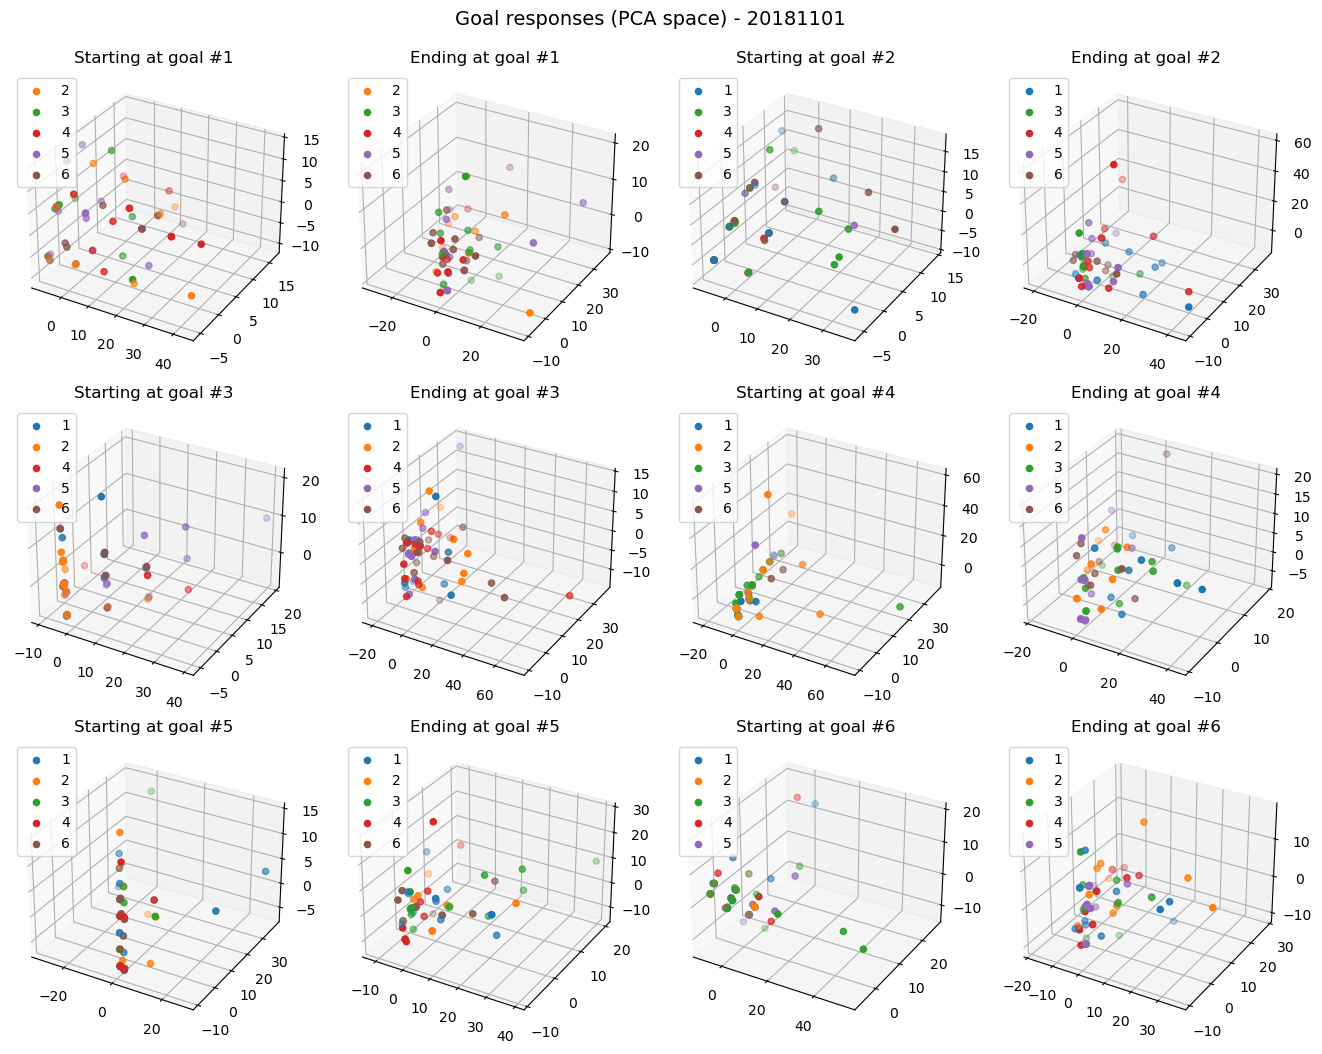

In [206]:
# Plots in PCA space for cue responses between different trajectories
fig = plt.figure(figsize=(16, 12))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.15, hspace=0.15)
plt.suptitle(f'Goal responses (PCA space) - {day_dir}', fontsize=14, y=0.95)

# Choose which frame to plot
frame_num = 1
for i in range(num_goals):
    ax = fig.add_subplot(3, 4, 2*i+1, projection='3d')
    ax.set_title(f'Starting at goal #{i+1}')
    for j, data in enumerate(pcspikerates_cue_per_traj[i]):
        if data.shape[0] > 0:
            ax.scatter(data[:,frame_num,0], data[:,frame_num,1], data[:,frame_num,2], color=f'C{j}', label=j+1)
    ax.legend(loc='upper left')

    ax = fig.add_subplot(3, 4, 2*i+2, projection='3d')
    ax.set_title(f'Ending at goal #{i+1}')
    for j in range(num_goals):
        data = pcspikerates_cue_per_traj[j][i]
        if data.shape[0] > 0:
            ax.scatter(data[:,frame_num,0], data[:,frame_num,1], data[:,frame_num,2], color=f'C{j}', label=j+1)
    ax.legend(loc='upper left')

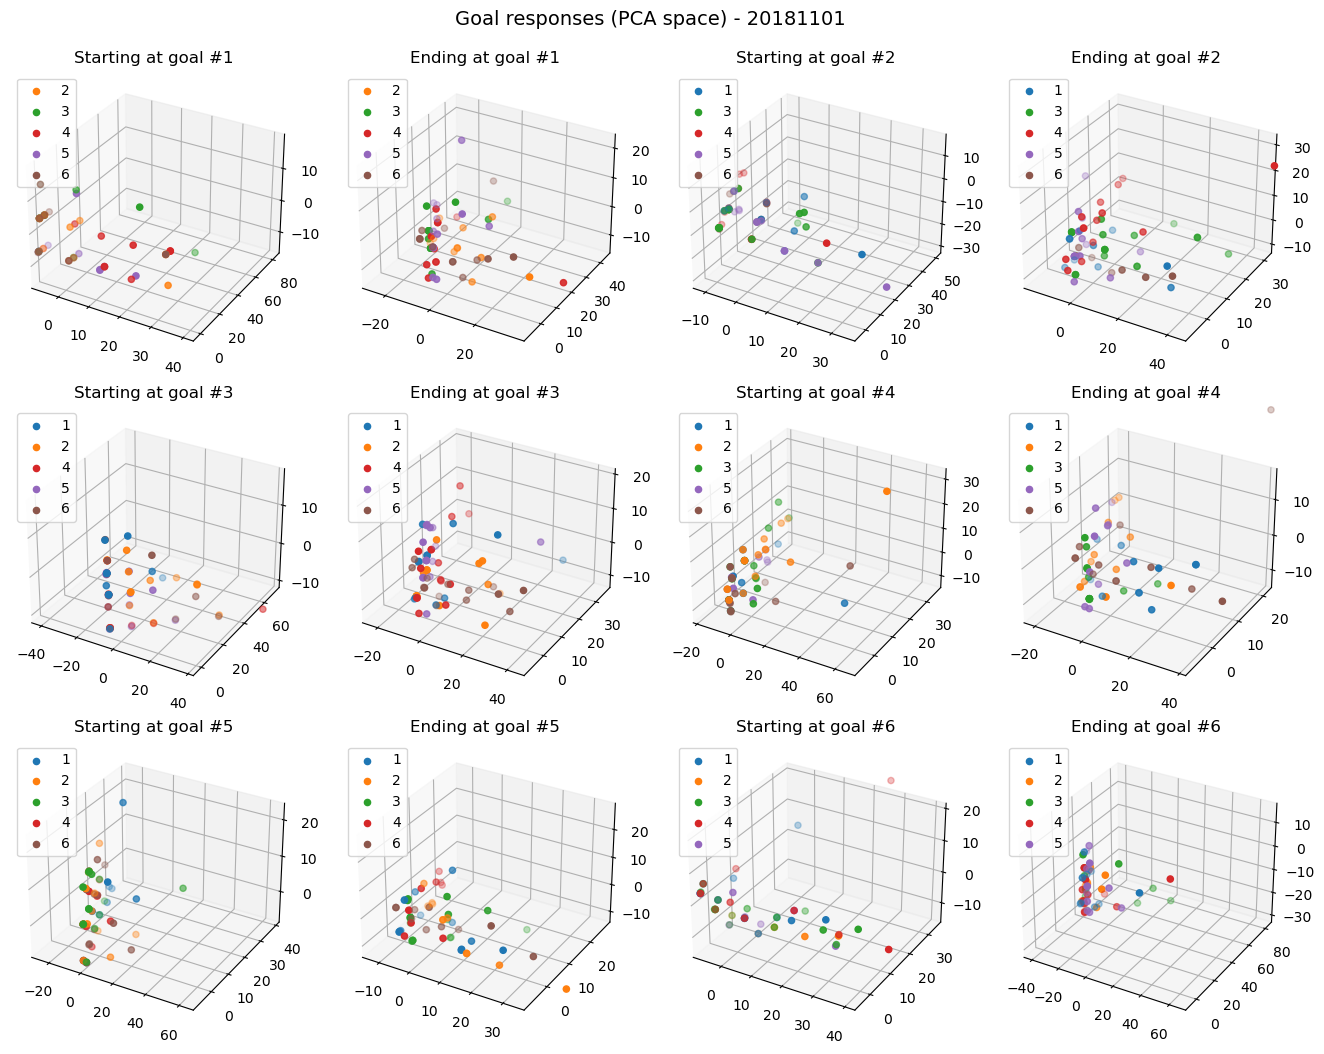

In [207]:
# Plots in PCA space for cue responses between different trajectories
fig = plt.figure(figsize=(16, 12))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.15, hspace=0.15)
plt.suptitle(f'Goal responses (PCA space) - {day_dir}', fontsize=14, y=0.95)

sc_plots = dict()
for i in range(num_goals):
    ax = fig.add_subplot(3, 4, 2*i+1, projection='3d')
    ax.set_title(f'Starting at goal #{i+1}')
    ax_lims = [[0, 0] for _ in range(3)]
    for j, data in enumerate(pcspikerates_cue_per_traj[i]):
        if data.shape[0] > 0:
            sc = ax.scatter(data[:,0,0], data[:,0,1], data[:,0,2], color=f'C{j}', label=j+1)
            sc_plots[(i, j, 0)] = sc
            ax_lims[0][0] = min(ax_lims[0][0], np.percentile(data[:,:,0], 1, axis=None))
            ax_lims[0][1] = max(ax_lims[0][1], np.percentile(data[:,:,0], 99, axis=None))
            ax_lims[1][0] = min(ax_lims[1][0], np.percentile(data[:,:,1], 1, axis=None))
            ax_lims[1][1] = max(ax_lims[1][1], np.percentile(data[:,:,1], 99, axis=None))
            ax_lims[2][0] = min(ax_lims[2][0], np.percentile(data[:,:,2], 1, axis=None))
            ax_lims[2][1] = max(ax_lims[2][1], np.percentile(data[:,:,2], 99, axis=None))
    ax.legend(loc='upper left')
    ax.set_xlim(ax_lims[0][0], ax_lims[0][1])
    ax.set_ylim(ax_lims[1][0], ax_lims[1][1])
    ax.set_zlim(ax_lims[2][0], ax_lims[2][1])

    ax = fig.add_subplot(3, 4, 2*i+2, projection='3d')
    ax.set_title(f'Ending at goal #{i+1}')
    ax_lims = [[0, 0] for _ in range(3)]
    for j in range(num_goals):
        data = pcspikerates_cue_per_traj[j][i]
        if data.shape[0] > 0:
            sc = ax.scatter(data[:,0,0], data[:,0,1], data[:,0,2], color=f'C{j}', label=j+1)
            sc_plots[(i, j, 1)] = sc
            ax_lims[0][0] = min(ax_lims[0][0], np.percentile(data[:,:,0], 1, axis=None))
            ax_lims[0][1] = max(ax_lims[0][1], np.percentile(data[:,:,0], 99, axis=None))
            ax_lims[1][0] = min(ax_lims[1][0], np.percentile(data[:,:,1], 1, axis=None))
            ax_lims[1][1] = max(ax_lims[1][1], np.percentile(data[:,:,1], 99, axis=None))
            ax_lims[2][0] = min(ax_lims[2][0], np.percentile(data[:,:,2], 1, axis=None))
            ax_lims[2][1] = max(ax_lims[2][1], np.percentile(data[:,:,2], 99, axis=None))
    ax.legend(loc='upper left')
    ax.set_xlim(ax_lims[0][0], ax_lims[0][1])
    ax.set_ylim(ax_lims[1][0], ax_lims[1][1])
    ax.set_zlim(ax_lims[2][0], ax_lims[2][1])

def update(frame):
    for i in range(num_goals):
        for j in range(num_goals):
            data = pcspikerates_cue_per_traj[i][j]
            if data.shape[0] > 0:
                sc_plots[(i, j, 0)]._offsets3d = (data[:,frame,0], data[:,frame,1], data[:,frame,2])
            data = pcspikerates_cue_per_traj[j][i]
            if data.shape[0] > 0:
                sc_plots[(i, j, 1)]._offsets3d = (data[:,frame,0], data[:,frame,1], data[:,frame,2])

ani = FuncAnimation(fig, update, frames=10, interval=500, blit=False, repeat=True)
HTML(ani.to_html5_video())

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
ani.save(f'{figsave_dir}/responses_pca_trajectories.mp4', writer='ffmpeg')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


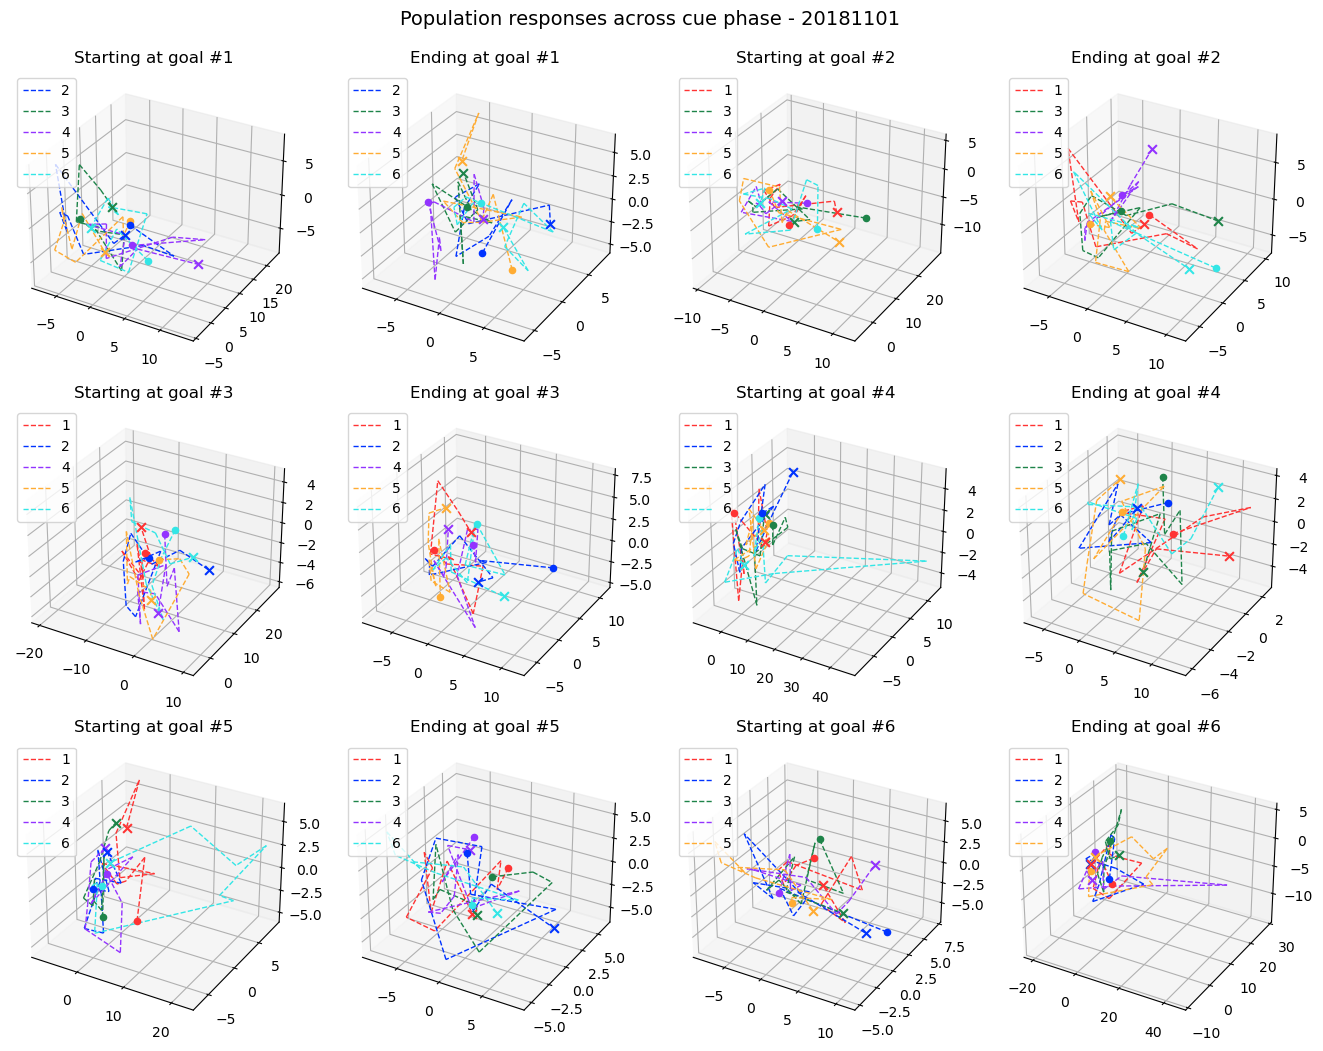

In [250]:
# Plots in PCA space for cue responses between different trajectories, mean of each group of points
fig = plt.figure(figsize=(16, 12))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.15, hspace=0.15)
plt.suptitle(f'Population responses across cue phase - {day_dir}', fontsize=14, y=0.95)
colours = ['#ff3333', '#0033ff', '#1e8449', '#9333ff', '#ffac33', '#33e6e6']

# Choose which frame to plot
for i in range(num_goals):
    ax = fig.add_subplot(3, 4, 2*i+1, projection='3d')
    ax.set_title(f'Starting at goal #{i+1}')
    for j, data in enumerate(pcspikerates_cue_per_traj_avg[i]):
        if data.shape[0] > 0:
            for k in range(data.shape[1]-1):
                if k == data.shape[1] - 2:
                    ax.plot(data[0,k:k+2,0], data[0,k:k+2,1], data[0,k:k+2,2], linestyle='--', linewidth=1, color=colours[j], label=j+1)
                else:
                    ax.plot(data[0,k:k+2,0], data[0,k:k+2,1], data[0,k:k+2,2], linestyle='--', linewidth=1, color=colours[j])
            ax.scatter(data[0,0,0], data[0,0,1], data[0,0,2], marker='.', color=colours[j], s=80)
            ax.scatter(data[0,-1,0], data[0,-1,1], data[0,-1,2], marker='x', color=colours[j], s=40)
    ax.legend(loc='upper left')

    ax = fig.add_subplot(3, 4, 2*i+2, projection='3d')
    ax.set_title(f'Ending at goal #{i+1}')
    for j in range(num_goals):
        data = pcspikerates_cue_per_traj_avg[j][i]
        if data.shape[0] > 0:
            for k in range(data.shape[1]-1):
                if k == data.shape[1] - 2 :
                    ax.plot(data[0,k:k+2,0], data[0,k:k+2,1], data[0,k:k+2,2], linestyle='--', linewidth=1, color=colours[j], label=j+1)
                else:
                    ax.plot(data[0,k:k+2,0], data[0,k:k+2,1], data[0,k:k+2,2], linestyle='--', linewidth=1, color=colours[j])
            ax.scatter(data[0,0,0], data[0,0,1], data[0,0,2], marker='.', color=colours[j], s=80)
            ax.scatter(data[0,-1,0], data[0,-1,1], data[0,-1,2], marker='x', color=colours[j], s=40)
    ax.legend(loc='upper left')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/responses_pca_mean.eps', bbox_inches='tight')

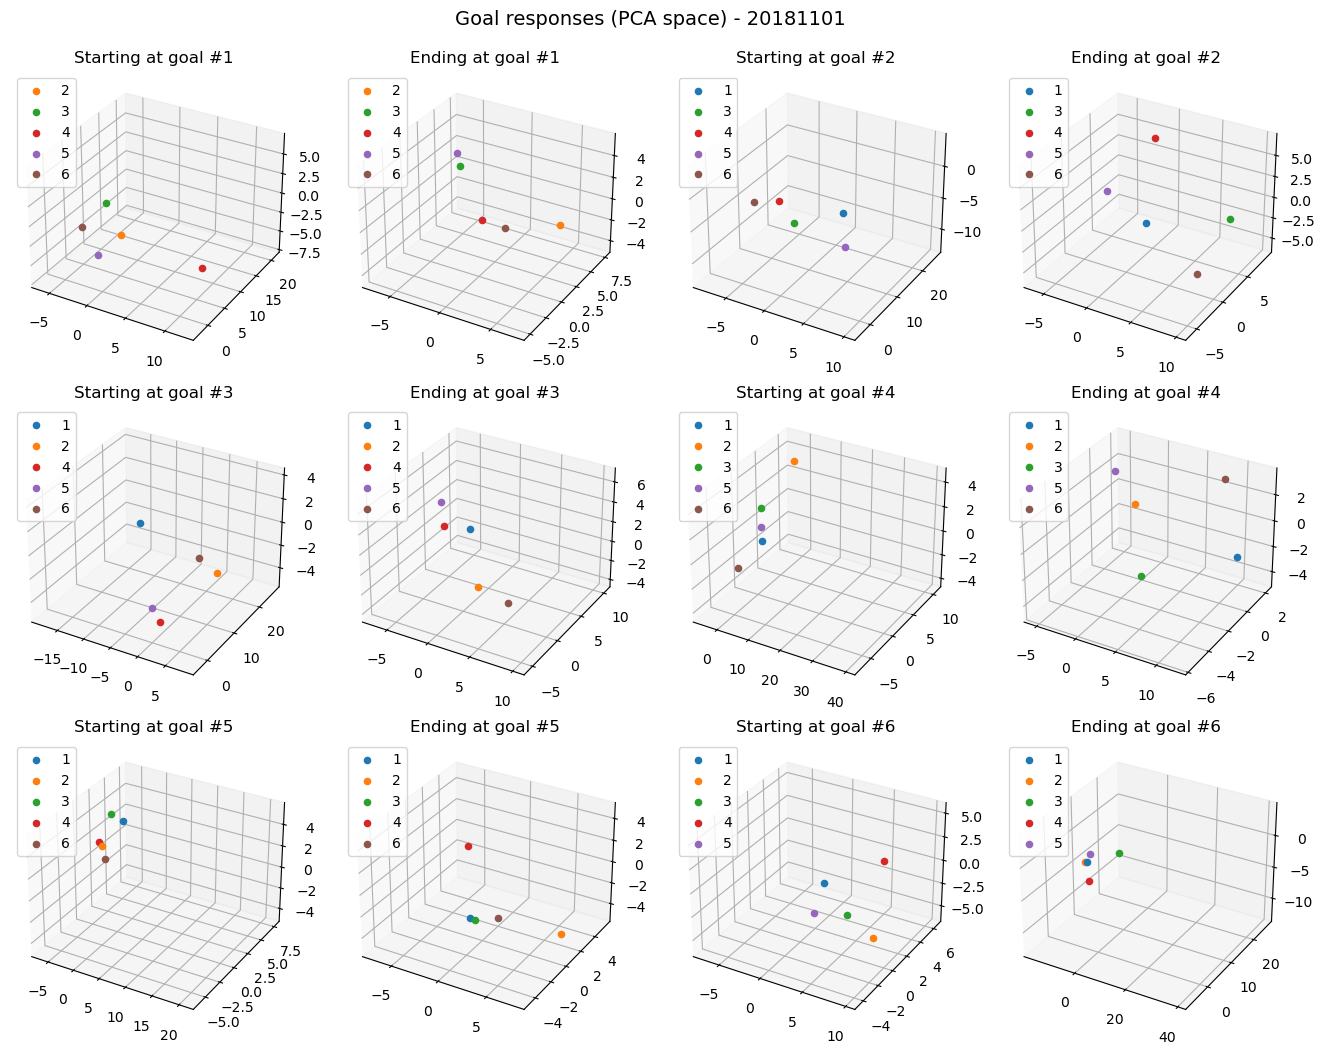

In [209]:
# Plots in PCA space for cue responses between different trajectories
fig = plt.figure(figsize=(16, 12))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.15, hspace=0.15)
plt.suptitle(f'Goal responses (PCA space) - {day_dir}', fontsize=14, y=0.95)

sc_plots = dict()
for i in range(num_goals):
    ax = fig.add_subplot(3, 4, 2*i+1, projection='3d')
    ax.set_title(f'Starting at goal #{i+1}')
    ax_lims = [[0, 0] for _ in range(3)]
    for j, data in enumerate(pcspikerates_cue_per_traj_avg[i]):
        if data.shape[0] > 0:
            sc = ax.scatter(data[:,0,0], data[:,0,1], data[:,0,2], color=f'C{j}', label=j+1)
            sc_plots[(i, j, 0)] = sc
            ax_lims[0][0] = min(ax_lims[0][0], np.percentile(data[:,:,0], 1, axis=None))
            ax_lims[0][1] = max(ax_lims[0][1], np.percentile(data[:,:,0], 99, axis=None))
            ax_lims[1][0] = min(ax_lims[1][0], np.percentile(data[:,:,1], 1, axis=None))
            ax_lims[1][1] = max(ax_lims[1][1], np.percentile(data[:,:,1], 99, axis=None))
            ax_lims[2][0] = min(ax_lims[2][0], np.percentile(data[:,:,2], 1, axis=None))
            ax_lims[2][1] = max(ax_lims[2][1], np.percentile(data[:,:,2], 99, axis=None))
    ax.legend(loc='upper left')
    ax.set_xlim(ax_lims[0][0], ax_lims[0][1])
    ax.set_ylim(ax_lims[1][0], ax_lims[1][1])
    ax.set_zlim(ax_lims[2][0], ax_lims[2][1])

    ax = fig.add_subplot(3, 4, 2*i+2, projection='3d')
    ax.set_title(f'Ending at goal #{i+1}')
    ax_lims = [[0, 0] for _ in range(3)]
    for j in range(num_goals):
        data = pcspikerates_cue_per_traj_avg[j][i]
        if data.shape[0] > 0:
            sc = ax.scatter(data[:,0,0], data[:,0,1], data[:,0,2], color=f'C{j}', label=j+1)
            sc_plots[(i, j, 1)] = sc
            ax_lims[0][0] = min(ax_lims[0][0], np.percentile(data[:,:,0], 1, axis=None))
            ax_lims[0][1] = max(ax_lims[0][1], np.percentile(data[:,:,0], 99, axis=None))
            ax_lims[1][0] = min(ax_lims[1][0], np.percentile(data[:,:,1], 1, axis=None))
            ax_lims[1][1] = max(ax_lims[1][1], np.percentile(data[:,:,1], 99, axis=None))
            ax_lims[2][0] = min(ax_lims[2][0], np.percentile(data[:,:,2], 1, axis=None))
            ax_lims[2][1] = max(ax_lims[2][1], np.percentile(data[:,:,2], 99, axis=None))
    ax.legend(loc='upper left')
    ax.set_xlim(ax_lims[0][0], ax_lims[0][1])
    ax.set_ylim(ax_lims[1][0], ax_lims[1][1])
    ax.set_zlim(ax_lims[2][0], ax_lims[2][1])

def update(frame):
    for i in range(num_goals):
        for j in range(num_goals):
            data = pcspikerates_cue_per_traj_avg[i][j]
            if data.shape[0] > 0:
                sc_plots[(i, j, 0)]._offsets3d = (data[:,frame,0], data[:,frame,1], data[:,frame,2])
            data = pcspikerates_cue_per_traj_avg[j][i]
            if data.shape[0] > 0:
                sc_plots[(i, j, 1)]._offsets3d = (data[:,frame,0], data[:,frame,1], data[:,frame,2])

ani = FuncAnimation(fig, update, frames=10, interval=500, blit=False, repeat=True)
HTML(ani.to_html5_video())

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
ani.save(f'{figsave_dir}/responses_pca_mean.mp4', writer='ffmpeg')

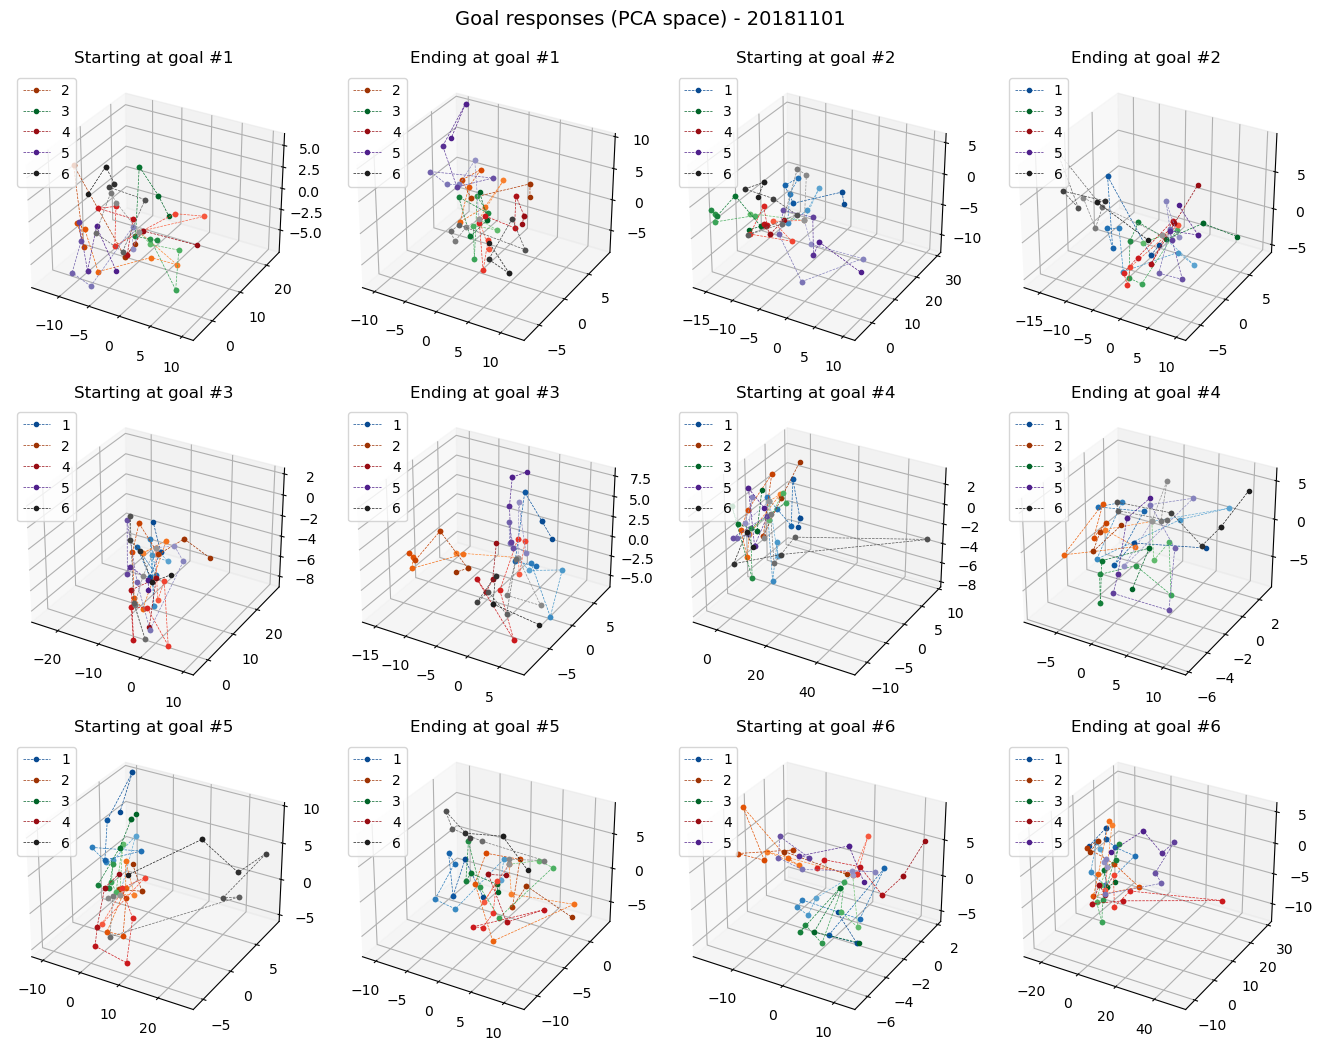

In [210]:
# Plots in PCA space for cue responses between different trajectories, relative to the starting time bin (first 100 ms)
fig = plt.figure(figsize=(16, 12))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.15, hspace=0.15)
plt.suptitle(f'Goal responses (PCA space) - {day_dir}', fontsize=14, y=0.95)
colormaps = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples', 'Greys']

# Choose which frame to plot
for i in range(num_goals):
    ax = fig.add_subplot(3, 4, 2*i+1, projection='3d')
    ax.set_title(f'Starting at goal #{i+1}')
    for j, data in enumerate(pcspikerates_cue_per_traj_start[i]):
        if data.shape[0] > 0:
            cmap = plt.get_cmap(colormaps[j])
            for k in range(data.shape[1]-1):
                color = cmap(k/(2*data.shape[1]) + 0.5)
                if k == data.shape[1] - 2:
                    ax.plot(data[0,k:k+2,0], data[0,k:k+2,1], data[0,k:k+2,2], marker='.', linestyle='--', linewidth=0.5, color=color, label=j+1)
                else:
                    ax.plot(data[0,k:k+2,0], data[0,k:k+2,1], data[0,k:k+2,2], marker='.', linestyle='--', linewidth=0.5, color=color)
    ax.legend(loc='upper left')

    ax = fig.add_subplot(3, 4, 2*i+2, projection='3d')
    ax.set_title(f'Ending at goal #{i+1}')
    for j in range(num_goals):
        data = pcspikerates_cue_per_traj_start[j][i]
        if data.shape[0] > 0:
            cmap = plt.get_cmap(colormaps[j])
            for k in range(data.shape[1]-1):
                color = cmap(k/(2*data.shape[1]) + 0.5)
                if k == data.shape[1] -2 :
                    ax.plot(data[0,k:k+2,0], data[0,k:k+2,1], data[0,k:k+2,2], marker='.', linestyle='--', linewidth=0.5, color=color, label=j+1)
                else:
                    ax.plot(data[0,k:k+2,0], data[0,k:k+2,1], data[0,k:k+2,2], marker='.', linestyle='--', linewidth=0.5, color=color)
    ax.legend(loc='upper left')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/responses_pca_start.png', bbox_inches='tight')

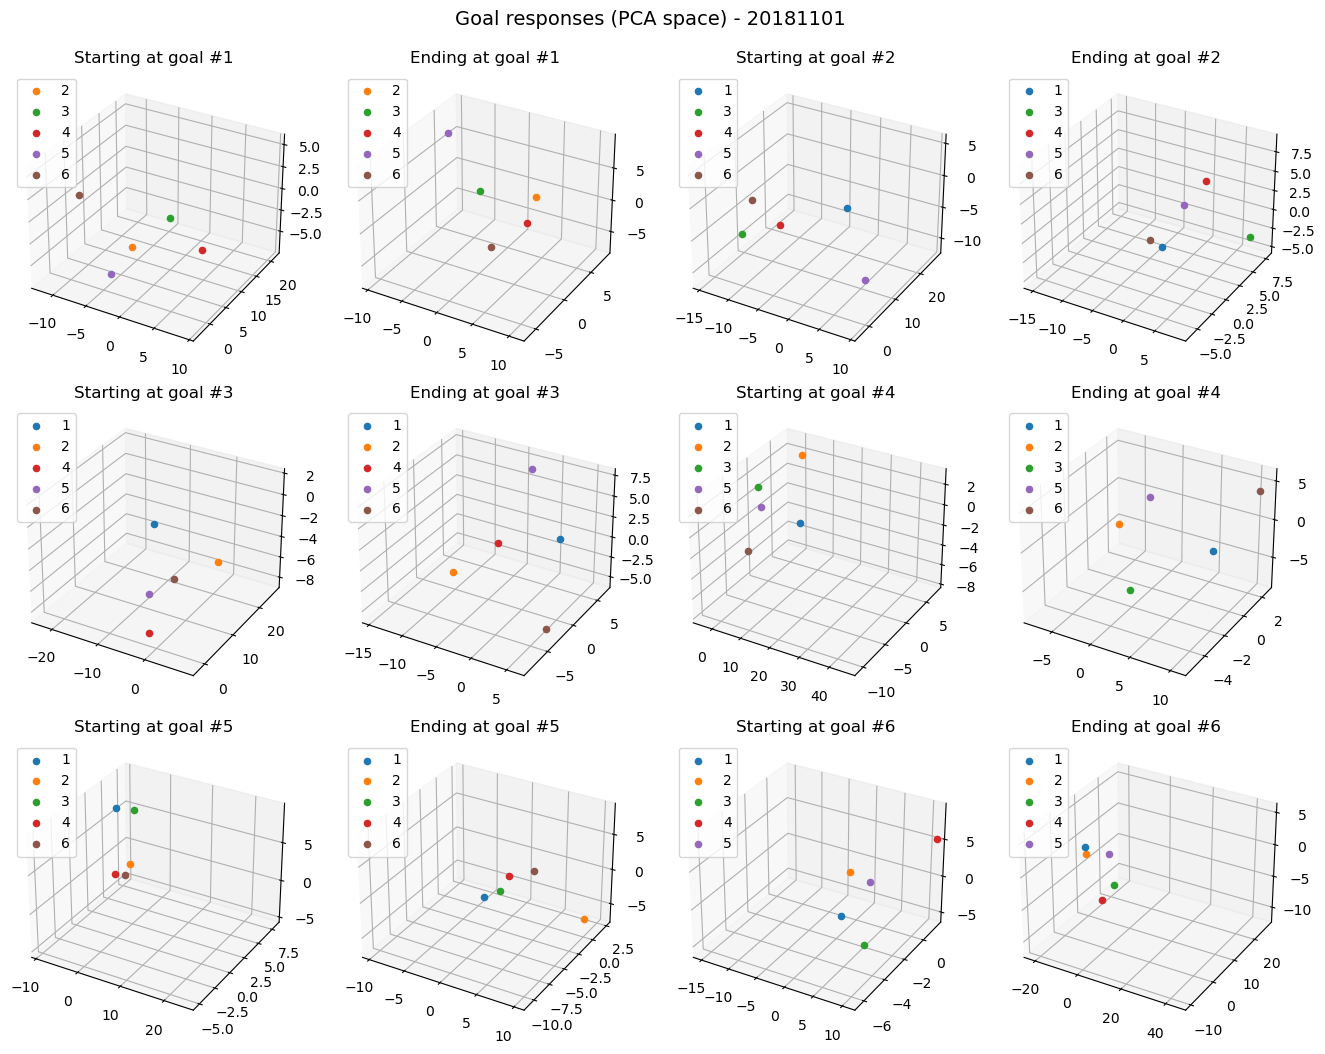

In [211]:
# Plots in PCA space for cue responses between different trajectories
fig = plt.figure(figsize=(16, 12))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.15, hspace=0.15)
plt.suptitle(f'Goal responses (PCA space) - {day_dir}', fontsize=14, y=0.95)

sc_plots = dict()
for i in range(num_goals):
    ax = fig.add_subplot(3, 4, 2*i+1, projection='3d')
    ax.set_title(f'Starting at goal #{i+1}')
    ax_lims = [[0, 0] for _ in range(3)]
    for j, data in enumerate(pcspikerates_cue_per_traj_start[i]):
        if data.shape[0] > 0:
            sc = ax.scatter(data[:,0,0], data[:,0,1], data[:,0,2], color=f'C{j}', label=j+1)
            sc_plots[(i, j, 0)] = sc
            ax_lims[0][0] = min(ax_lims[0][0], np.percentile(data[:,:,0], 1, axis=None))
            ax_lims[0][1] = max(ax_lims[0][1], np.percentile(data[:,:,0], 99, axis=None))
            ax_lims[1][0] = min(ax_lims[1][0], np.percentile(data[:,:,1], 1, axis=None))
            ax_lims[1][1] = max(ax_lims[1][1], np.percentile(data[:,:,1], 99, axis=None))
            ax_lims[2][0] = min(ax_lims[2][0], np.percentile(data[:,:,2], 1, axis=None))
            ax_lims[2][1] = max(ax_lims[2][1], np.percentile(data[:,:,2], 99, axis=None))
    ax.legend(loc='upper left')
    ax.set_xlim(ax_lims[0][0], ax_lims[0][1])
    ax.set_ylim(ax_lims[1][0], ax_lims[1][1])
    ax.set_zlim(ax_lims[2][0], ax_lims[2][1])

    ax = fig.add_subplot(3, 4, 2*i+2, projection='3d')
    ax.set_title(f'Ending at goal #{i+1}')
    ax_lims = [[0, 0] for _ in range(3)]
    for j in range(num_goals):
        data = pcspikerates_cue_per_traj_start[j][i]
        if data.shape[0] > 0:
            sc = ax.scatter(data[:,0,0], data[:,0,1], data[:,0,2], color=f'C{j}', label=j+1)
            sc_plots[(i, j, 1)] = sc
            ax_lims[0][0] = min(ax_lims[0][0], np.percentile(data[:,:,0], 1, axis=None))
            ax_lims[0][1] = max(ax_lims[0][1], np.percentile(data[:,:,0], 99, axis=None))
            ax_lims[1][0] = min(ax_lims[1][0], np.percentile(data[:,:,1], 1, axis=None))
            ax_lims[1][1] = max(ax_lims[1][1], np.percentile(data[:,:,1], 99, axis=None))
            ax_lims[2][0] = min(ax_lims[2][0], np.percentile(data[:,:,2], 1, axis=None))
            ax_lims[2][1] = max(ax_lims[2][1], np.percentile(data[:,:,2], 99, axis=None))
    ax.legend(loc='upper left')
    ax.set_xlim(ax_lims[0][0], ax_lims[0][1])
    ax.set_ylim(ax_lims[1][0], ax_lims[1][1])
    ax.set_zlim(ax_lims[2][0], ax_lims[2][1])

def update(frame):
    for i in range(num_goals):
        for j in range(num_goals):
            data = pcspikerates_cue_per_traj_start[i][j]
            if data.shape[0] > 0:
                sc_plots[(i, j, 0)]._offsets3d = (data[:,frame,0], data[:,frame,1], data[:,frame,2])
            data = pcspikerates_cue_per_traj_start[j][i]
            if data.shape[0] > 0:
                sc_plots[(i, j, 1)]._offsets3d = (data[:,frame,0], data[:,frame,1], data[:,frame,2])

ani = FuncAnimation(fig, update, frames=10, interval=500, blit=False, repeat=True)
HTML(ani.to_html5_video())

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
ani.save(f'{figsave_dir}/responses_pca_start.mp4', writer='ffmpeg')

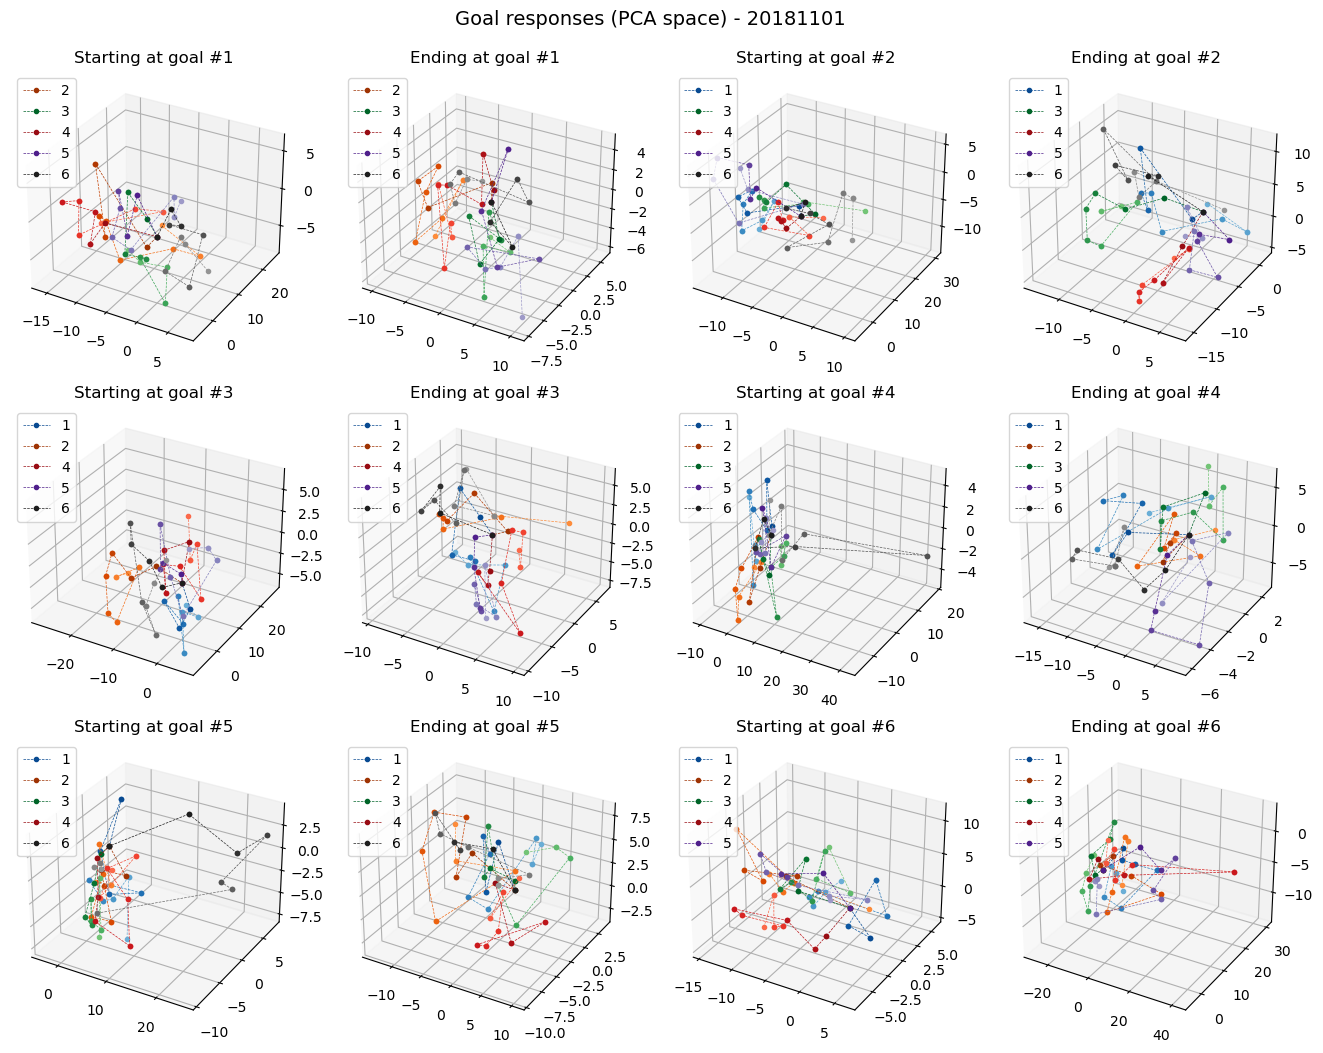

In [212]:
# Plots in PCA space for cue responses between different trajectories, relative to the starting time bin (first 100 ms)
fig = plt.figure(figsize=(16, 12))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.15, hspace=0.15)
plt.suptitle(f'Goal responses (PCA space) - {day_dir}', fontsize=14, y=0.95)
colormaps = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples', 'Greys']

# Choose which frame to plot
for i in range(num_goals):
    ax = fig.add_subplot(3, 4, 2*i+1, projection='3d')
    ax.set_title(f'Starting at goal #{i+1}')
    for j, data in enumerate(pcspikerates_cue_per_traj_end[i]):
        if data.shape[0] > 0:
            cmap = plt.get_cmap(colormaps[j])
            for k in range(data.shape[1]-1):
                color = cmap(k/(2*data.shape[1]) + 0.5)
                if k == data.shape[1] - 2:
                    ax.plot(data[0,k:k+2,0], data[0,k:k+2,1], data[0,k:k+2,2], marker='.', linestyle='--', linewidth=0.5, color=color, label=j+1)
                else:
                    ax.plot(data[0,k:k+2,0], data[0,k:k+2,1], data[0,k:k+2,2], marker='.', linestyle='--', linewidth=0.5, color=color)
    ax.legend(loc='upper left')

    ax = fig.add_subplot(3, 4, 2*i+2, projection='3d')
    ax.set_title(f'Ending at goal #{i+1}')
    for j in range(num_goals):
        data = pcspikerates_cue_per_traj_end[j][i]
        if data.shape[0] > 0:
            cmap = plt.get_cmap(colormaps[j])
            for k in range(data.shape[1]-1):
                color = cmap(k/(2*data.shape[1]) + 0.5)
                if k == data.shape[1] -2 :
                    ax.plot(data[0,k:k+2,0], data[0,k:k+2,1], data[0,k:k+2,2], marker='.', linestyle='--', linewidth=0.5, color=color, label=j+1)
                else:
                    ax.plot(data[0,k:k+2,0], data[0,k:k+2,1], data[0,k:k+2,2], marker='.', linestyle='--', linewidth=0.5, color=color)
    ax.legend(loc='upper left')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/responses_pca_end.png', bbox_inches='tight')

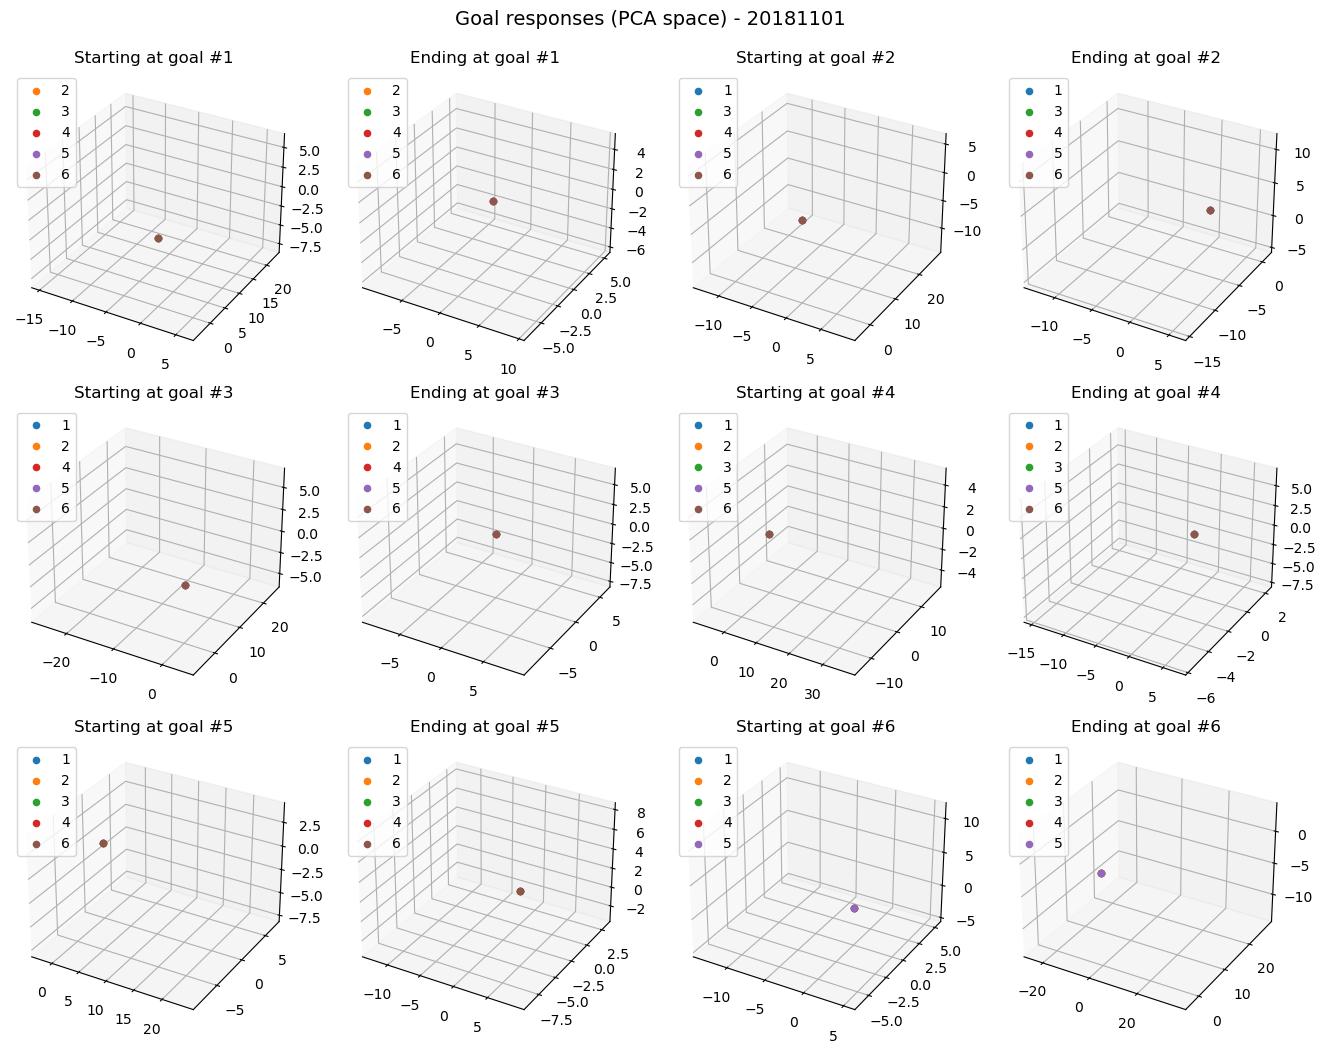

In [213]:
# Plots in PCA space for cue responses between different trajectories
fig = plt.figure(figsize=(16, 12))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.15, hspace=0.15)
plt.suptitle(f'Goal responses (PCA space) - {day_dir}', fontsize=14, y=0.95)

sc_plots = dict()
for i in range(num_goals):
    ax = fig.add_subplot(3, 4, 2*i+1, projection='3d')
    ax.set_title(f'Starting at goal #{i+1}')
    ax_lims = [[0, 0] for _ in range(3)]
    for j, data in enumerate(pcspikerates_cue_per_traj_end[i]):
        if data.shape[0] > 0:
            sc = ax.scatter(data[:,0,0], data[:,0,1], data[:,0,2], color=f'C{j}', label=j+1)
            sc_plots[(i, j, 0)] = sc
            ax_lims[0][0] = min(ax_lims[0][0], np.percentile(data[:,:,0], 1, axis=None))
            ax_lims[0][1] = max(ax_lims[0][1], np.percentile(data[:,:,0], 99, axis=None))
            ax_lims[1][0] = min(ax_lims[1][0], np.percentile(data[:,:,1], 1, axis=None))
            ax_lims[1][1] = max(ax_lims[1][1], np.percentile(data[:,:,1], 99, axis=None))
            ax_lims[2][0] = min(ax_lims[2][0], np.percentile(data[:,:,2], 1, axis=None))
            ax_lims[2][1] = max(ax_lims[2][1], np.percentile(data[:,:,2], 99, axis=None))
    ax.legend(loc='upper left')
    ax.set_xlim(ax_lims[0][0], ax_lims[0][1])
    ax.set_ylim(ax_lims[1][0], ax_lims[1][1])
    ax.set_zlim(ax_lims[2][0], ax_lims[2][1])

    ax = fig.add_subplot(3, 4, 2*i+2, projection='3d')
    ax.set_title(f'Ending at goal #{i+1}')
    ax_lims = [[0, 0] for _ in range(3)]
    for j in range(num_goals):
        data = pcspikerates_cue_per_traj_end[j][i]
        if data.shape[0] > 0:
            sc = ax.scatter(data[:,0,0], data[:,0,1], data[:,0,2], color=f'C{j}', label=j+1)
            sc_plots[(i, j, 1)] = sc
            ax_lims[0][0] = min(ax_lims[0][0], np.percentile(data[:,:,0], 1, axis=None))
            ax_lims[0][1] = max(ax_lims[0][1], np.percentile(data[:,:,0], 99, axis=None))
            ax_lims[1][0] = min(ax_lims[1][0], np.percentile(data[:,:,1], 1, axis=None))
            ax_lims[1][1] = max(ax_lims[1][1], np.percentile(data[:,:,1], 99, axis=None))
            ax_lims[2][0] = min(ax_lims[2][0], np.percentile(data[:,:,2], 1, axis=None))
            ax_lims[2][1] = max(ax_lims[2][1], np.percentile(data[:,:,2], 99, axis=None))
    ax.legend(loc='upper left')
    ax.set_xlim(ax_lims[0][0], ax_lims[0][1])
    ax.set_ylim(ax_lims[1][0], ax_lims[1][1])
    ax.set_zlim(ax_lims[2][0], ax_lims[2][1])

def update(frame):
    for i in range(num_goals):
        for j in range(num_goals):
            data = pcspikerates_cue_per_traj_end[i][j]
            if data.shape[0] > 0:
                sc_plots[(i, j, 0)]._offsets3d = (data[:,frame,0], data[:,frame,1], data[:,frame,2])
            data = pcspikerates_cue_per_traj_end[j][i]
            if data.shape[0] > 0:
                sc_plots[(i, j, 1)]._offsets3d = (data[:,frame,0], data[:,frame,1], data[:,frame,2])

ani = FuncAnimation(fig, update, frames=10, interval=500, blit=False, repeat=True)
HTML(ani.to_html5_video())

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
ani.save(f'{figsave_dir}/responses_pca_end.mp4', writer='ffmpeg')

### Save data to pkl file

In [214]:
datasave_dir = 'data/pcaview'
for i, label in enumerate(cell_labels):
    label = label.split('/')
    label[1] = label[1][2:]
    if label[1][0] == '0':
        label[1] = label[1][1:]
    cell_labels[i] = f'{day_dir}ch{label[1]}{label[2]}'
data = {'spikerates_cue': spikerates_cue, 'goals_cue': goals_cue, 'trajectories_cue': trajectories_cue, 'cell_labels': cell_labels}
if not os.path.exists(datasave_dir):
    os.makedirs(datasave_dir)
with open(f'{datasave_dir}/{day_dir}_data.pkl', 'wb') as file:
    pickle.dump(data, file)

### Pseudopopulation analysis

In [476]:
# Load data from .pkl files
day_list = ['20181105', '20181102', '20181101']
num_sess = len(day_list)

all_spikerates_cue = list()
all_goals_cue = list()
all_trajectories_cue = list()
for day in day_list:
    with open(f'data/pcaview/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        # Drop the first trial from each day's dataset
        all_spikerates_cue.append(data['spikerates_cue'][1:])
        all_goals_cue.append(data['goals_cue'][1:])
        all_trajectories_cue.append(data['trajectories_cue'][1:])

In [477]:
all_spikerates_cue_per_traj = list()
for i in range(num_sess):
    all_spikerates_cue_per_traj.append(group_by_trajectory(all_spikerates_cue[i], all_trajectories_cue[i]))

# Append cells from each session to form a pseudopopulation, append in chronological order on responses grouped by (start, end) goals
trajectories = list(all_spikerates_cue_per_traj[0].keys())
combined_spikerates_cue_per_traj = {key: list() for key in trajectories}
for traj in trajectories:
    trials_data = [sess[traj] for sess in all_spikerates_cue_per_traj]
    num_trials = min(map(len, trials_data))
    for trial in range(num_trials):
        combined_spikerates_cue_per_traj[traj].append(np.hstack([sess[trial] for sess in trials_data]))

In [489]:
# Group cue phase responses according to trajectory, then group by same start goal and same end goal
combined_spikerates_cue_start_goals, combined_spikerates_cue_end_goals = [list() for _ in range(num_goals)], [list() for _ in range(num_goals)]
combined_start_goals_labels, combined_end_goals_labels = [list() for _ in range(num_goals)], [list() for _ in range(num_goals)]
for traj, responses in combined_spikerates_cue_per_traj.items():
    start_goal, end_goal = traj[0] - 1, traj[1] - 1
    combined_spikerates_cue_start_goals[start_goal].extend(responses)
    combined_start_goals_labels[start_goal].extend(len(responses) * [end_goal + 1])
    combined_spikerates_cue_end_goals[end_goal].extend(responses)
    combined_end_goals_labels[end_goal].extend(len(responses) * [start_goal + 1])

# Fit PCA within each group of same starting/same ending goal
pca = PCA(n_components=3)
combined_pcspikerates_cue_start_goals, combined_pcspikerates_cue_end_goals = list(), list()
for i in range(num_goals):
    pc_start_goals = pca.fit_transform(np.vstack(combined_spikerates_cue_start_goals[i]))
    pc_end_goals = pca.fit_transform(np.vstack(combined_spikerates_cue_end_goals[i]))
    combined_pcspikerates_cue_start_goals.append(np.array([pc_start_goals[10*j:10*(j+1),:] for j in range(pc_start_goals.shape[0]//10)]))
    combined_pcspikerates_cue_end_goals.append(np.array([pc_end_goals[10*j:10*(j+1),:] for j in range(pc_end_goals.shape[0]//10)]))

# Regroup into trajectories for plotting
combined_pcspikerates_cue_per_traj = [[np.empty((0, 10, 3)) for i in range(num_goals)] for j in range(num_goals)]
for i in range(num_goals):
    for j, data in enumerate(combined_pcspikerates_cue_start_goals[i]):
        k = combined_start_goals_labels[i][j] - 1
        combined_pcspikerates_cue_per_traj[i][k] = np.concatenate([combined_pcspikerates_cue_per_traj[i][k], data.reshape(-1, 10, 3)], axis=0)

In [490]:
# Plot the average response per trajectory
combined_pcspikerates_cue_per_traj_avg = [[np.empty((0, 10, 3)) for i in range(num_goals)] for j in range(num_goals)]
for i in range(num_goals):
    for j, data in enumerate(combined_pcspikerates_cue_per_traj[i]):
        if i == j:
            continue
        combined_pcspikerates_cue_per_traj_avg[i][j] = np.concatenate([combined_pcspikerates_cue_per_traj_avg[i][j], np.mean(data, axis=0).reshape(1, 10, 3)], axis=0)

# Subtract the first frame from all subsequent frames to get the displacement from start
combined_pcspikerates_cue_per_traj_ref = [[combined_pcspikerates_cue_per_traj_avg[i][j][:,0,:] for j in range(num_goals)] for i in range(num_goals)]
combined_pcspikerates_cue_per_traj_start = [[combined_pcspikerates_cue_per_traj_avg[i][j].copy() for j in range(num_goals)] for i in range(num_goals)]
for i in range(num_goals):
    for j in range(num_goals):
        if i == j:
            continue
        combined_pcspikerates_cue_per_traj_start[i][j] -= combined_pcspikerates_cue_per_traj_ref[i][j]

# Subtract the last frame from all previous frames to get the displacement from end
combined_pcspikerates_cue_per_traj_ref = [[combined_pcspikerates_cue_per_traj_avg[i][j][:,-1,:] for j in range(num_goals)] for i in range(num_goals)]
combined_pcspikerates_cue_per_traj_end = [[combined_pcspikerates_cue_per_traj_avg[i][j].copy() for j in range(num_goals)] for i in range(num_goals)]
for i in range(num_goals):
    for j in range(num_goals):
        if i == j:
            continue
        combined_pcspikerates_cue_per_traj_end[i][j] -= combined_pcspikerates_cue_per_traj_ref[i][j]

In [491]:
class DiscreteFrechet(object):
    """
    Calculates the discrete Fréchet distance between two poly-lines using the
    original recursive algorithm
    """

    def __init__(self, dist_func):
        """
        Initializes the instance with a pairwise distance function.
        :param dist_func: The distance function. It must accept two NumPy
        arrays containing the point coordinates (x, y), (lat, long)
        """
        self.dist_func = dist_func
        self.ca = np.array([0.0])

    def distance(self, p: np.ndarray, q: np.ndarray) -> float:
        """
        Calculates the Fréchet distance between poly-lines p and q
        This function implements the algorithm described by Eiter & Mannila
        :param p: Poly-line p
        :param q: Poly-line q
        :return: Distance value
        """

        def calculate(i: int, j: int) -> float:
            """
            Calculates the distance between p[i] and q[i]
            :param i: Index into poly-line p
            :param j: Index into poly-line q
            :return: Distance value
            """
            if self.ca[i, j] > -1.0:
                return self.ca[i, j]

            d = self.dist_func(p[i], q[j])
            if i == 0 and j == 0:
                self.ca[i, j] = d
            elif i > 0 and j == 0:
                self.ca[i, j] = max(calculate(i-1, 0), d)
            elif i == 0 and j > 0:
                self.ca[i, j] = max(calculate(0, j-1), d)
            elif i > 0 and j > 0:
                self.ca[i, j] = max(min(calculate(i-1, j),
                                        calculate(i-1, j-1),
                                        calculate(i, j-1)), d)
            else:
                self.ca[i, j] = np.infty
            return self.ca[i, j]

        n_p = p.shape[0]
        n_q = q.shape[0]
        self.ca = np.zeros((n_p, n_q))
        self.ca.fill(-1.0)
        return calculate(n_p - 1, n_q - 1)
    
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

frechet = DiscreteFrechet(euclidean_distance)

In [492]:
combined_pcspikerates_cue_per_traj_frechdist = [[dict(), dict()] for _ in range(num_goals)]
for i in range(num_goals):
    traj_pairs = list(range(num_goals))
    traj_pairs.remove(i)
    traj_pairs = list(combinations(traj_pairs, 2))
    for (j1, j2) in traj_pairs:
        combined_pcspikerates_cue_per_traj_frechdist[i][0][(j1, j2)] = frechet.distance(combined_pcspikerates_cue_per_traj_avg[i][j1], combined_pcspikerates_cue_per_traj_avg[i][j2])
        combined_pcspikerates_cue_per_traj_frechdist[i][1][(j1, j2)] = frechet.distance(combined_pcspikerates_cue_per_traj_avg[j1][i], combined_pcspikerates_cue_per_traj_avg[j2][i])

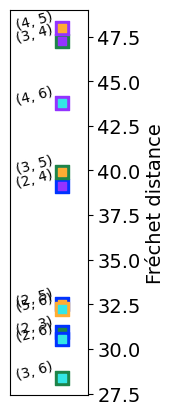

In [493]:
fig = plt.figure(figsize=(1, 5))
ax = fig.gca()

for (a, b), val in combined_pcspikerates_cue_per_traj_frechdist[0][0].items():
    ax.scatter(0, val, marker='s', s=100, color=colours[a], linewidth=1)
    ax.scatter(0, val, marker='s', s=40, color=colours[b], linewidth=1)
    ax.annotate(f'({a+1}, {b+1})', (0, val), textcoords="offset points", xytext=(-5, 5), ha='right', va='center', fontsize=10, rotation=15)
ax.set_xticks([])
ax.set_xlim([-2,1])
ax.set_ylabel('Fréchet distance')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

Text(0.5, 0, 'Fréchet distance')

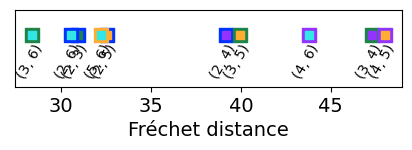

In [494]:
fig = plt.figure(figsize=(5, 1))
ax = fig.gca()

for (a, b), val in combined_pcspikerates_cue_per_traj_frechdist[0][0].items():
    ax.scatter(val, 0, marker='s', s=100, color=colours[a], linewidth=1)
    ax.scatter(val, 0, marker='s', s=40, color=colours[b], linewidth=1)
    ax.annotate(f'({a+1}, {b+1})', (val, 0), textcoords="offset points", xytext=(-2, -5), ha='center', va='top', fontsize=10, rotation=60)
ax.set_yticks([])
ax.set_ylim([-2, 1])
ax.set_xlabel('Fréchet distance')

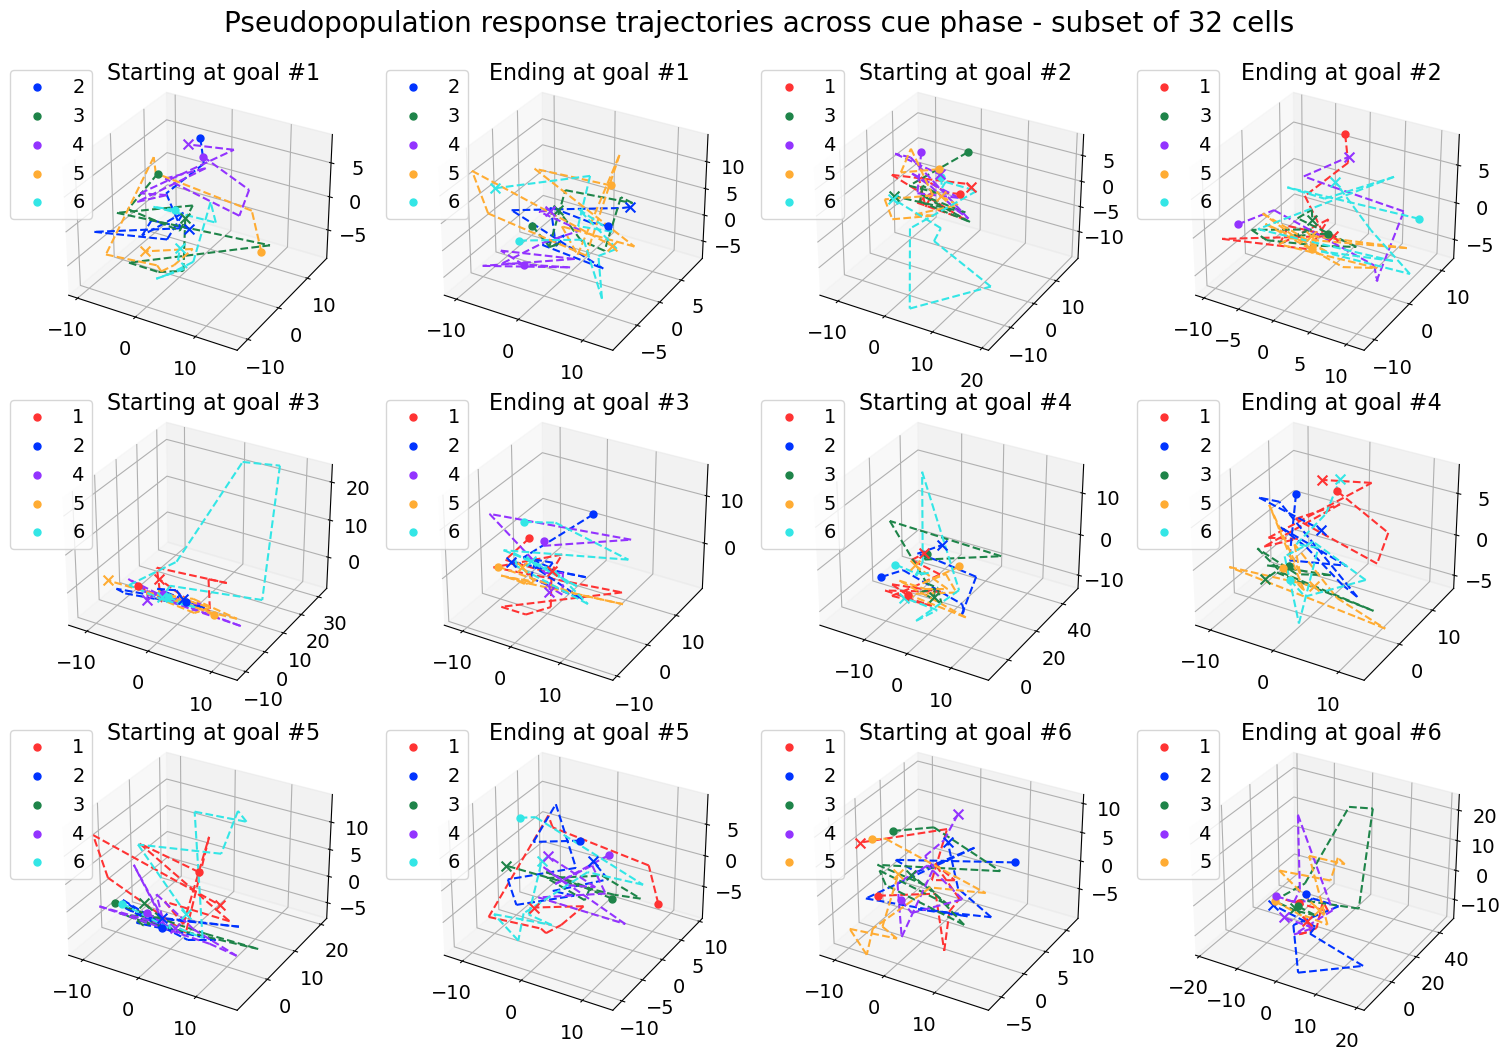

In [495]:
# Plots in PCA space for cue responses between different trajectories, mean of each group of points
fig = plt.figure(figsize=(18, 12))
plt.rcParams['font.size'] = 14
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.1)
plt.suptitle(f'Pseudopopulation response trajectories across cue phase - subset of 32 cells', fontsize=20, y=0.95)
colours = ['#ff3333', '#0033ff', '#1e8449', '#9333ff', '#ffac33', '#33e6e6']

for i in range(num_goals):
    ax = fig.add_subplot(3, 4, 2*i+1, projection='3d')
    ax.set_title(f'Starting at goal #{i+1}', fontsize=16, x=0.56, y=1.02)
    for j, data in enumerate(combined_pcspikerates_cue_per_traj_avg[i]):
        if data.shape[0] > 0:
            for k in range(data.shape[1]-1):
                ax.plot(data[0,k:k+2,0], data[0,k:k+2,1], data[0,k:k+2,2], linestyle='--', linewidth=1.5, color=colours[j])
            ax.scatter(data[0,0,0], data[0,0,1], data[0,0,2], marker='.', color=colours[j], s=100, label=j+1)
            ax.scatter(data[0,-1,0], data[0,-1,1], data[0,-1,2], marker='x', color=colours[j], s=50)
    ax.legend(loc=(-0.12, 0.5))

    ax = fig.add_subplot(3, 4, 2*i+2, projection='3d')
    ax.set_title(f'Ending at goal #{i+1}', fontsize=16, x=0.56, y=1.02)
    for j in range(num_goals):
        data = combined_pcspikerates_cue_per_traj_avg[j][i]
        if data.shape[0] > 0:
            for k in range(data.shape[1]-1):
                ax.plot(data[0,k:k+2,0], data[0,k:k+2,1], data[0,k:k+2,2], linestyle='--', linewidth=1.5, color=colours[j])
            ax.scatter(data[0,0,0], data[0,0,1], data[0,0,2], marker='.', color=colours[j], s=100, label=j+1)
            ax.scatter(data[0,-1,0], data[0,-1,1], data[0,-1,2], marker='x', color=colours[j], s=50)
    ax.legend(loc=(-0.12, 0.5))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


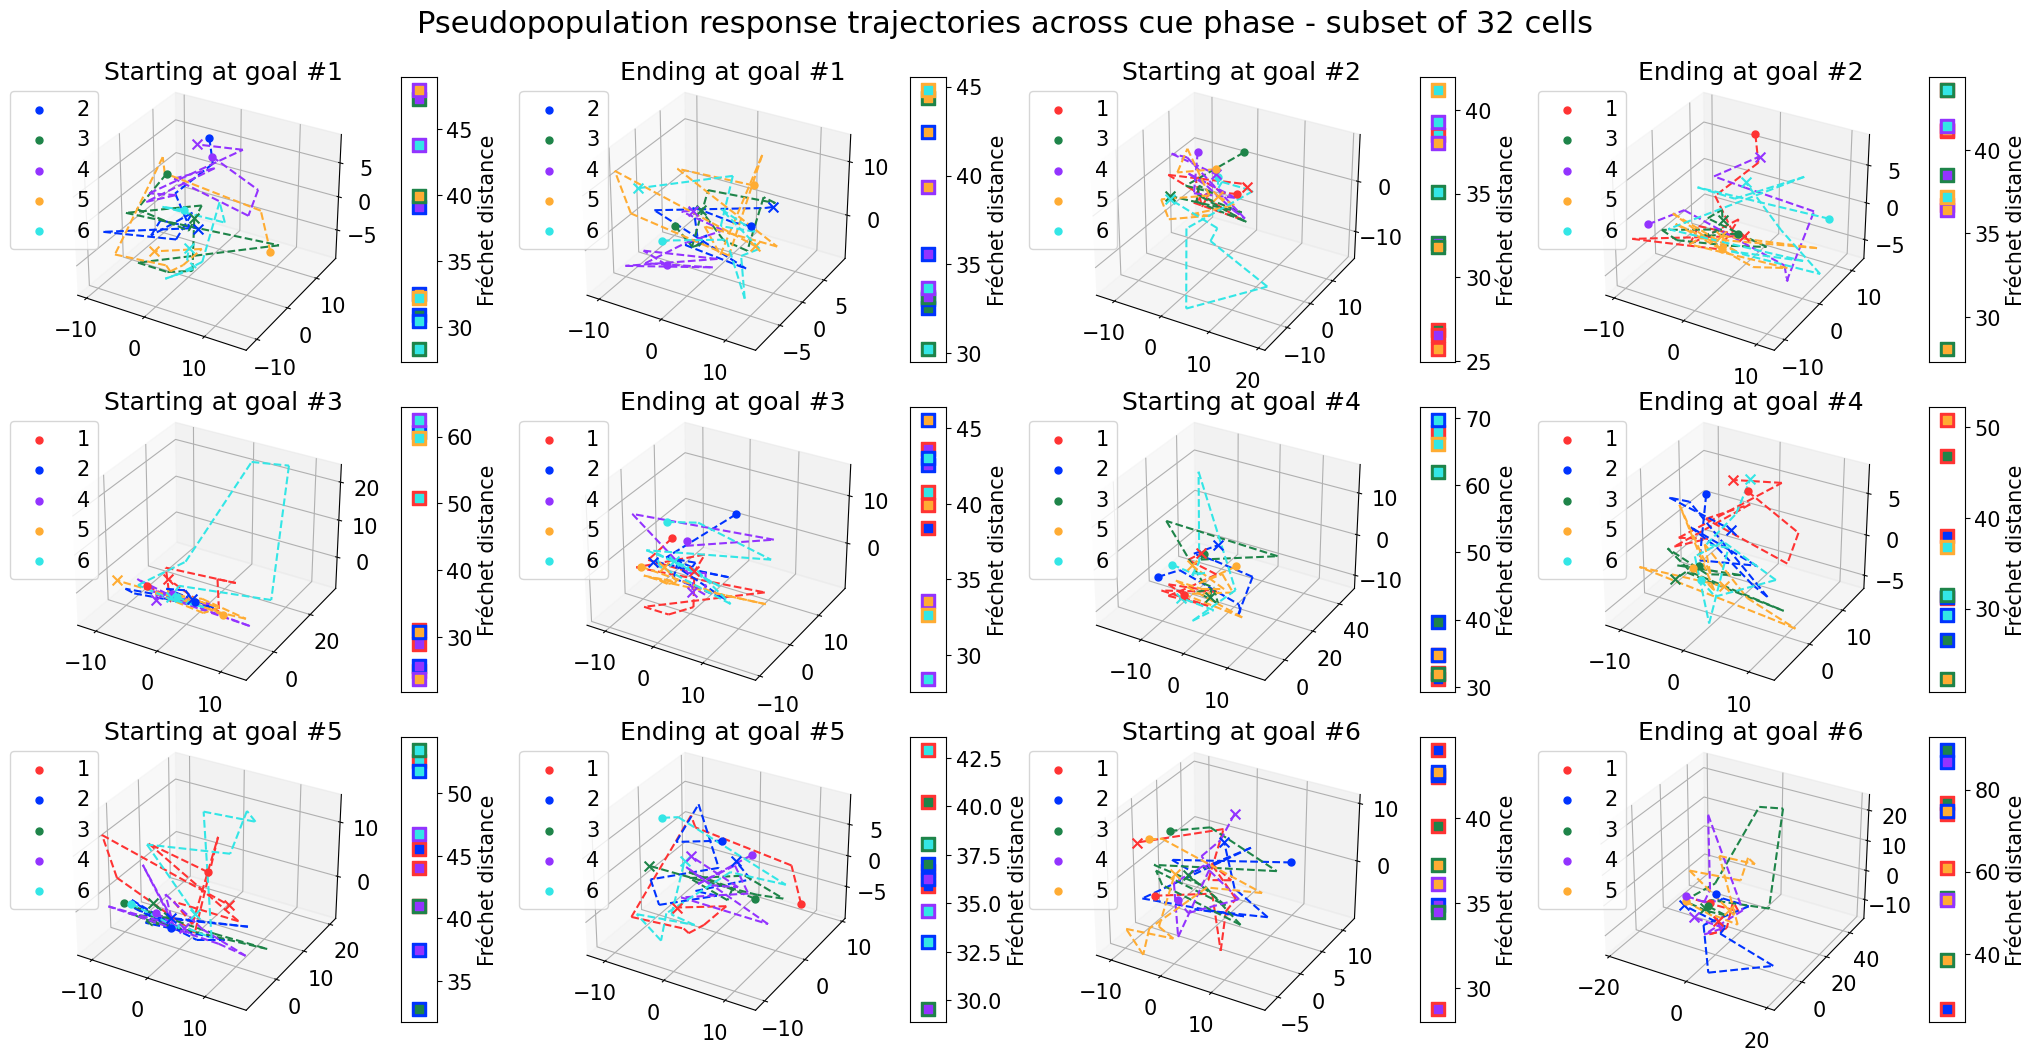

In [496]:
# Plots in PCA space for cue responses between different trajectories, mean of each group of points
fig = plt.figure(figsize=(24, 12))
outer_gs = GridSpec(3, 4)
plt.rcParams['font.size'] = 15
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.1)
plt.suptitle(f'Pseudopopulation response trajectories across cue phase - subset of 32 cells', fontsize=22, y=0.95)
colours = ['#ff3333', '#0033ff', '#1e8449', '#9333ff', '#ffac33', '#33e6e6']

for i in range(num_goals):
    inner_gs = outer_gs[2*i].subgridspec(1, 2, wspace=0.2, width_ratios=[9, 1])
    ax1 = fig.add_subplot(inner_gs[0], projection='3d')
    ax1.set_title(f'Starting at goal #{i+1}', fontsize=18, x=0.56, y=1.02)
    for j, data in enumerate(combined_pcspikerates_cue_per_traj_avg[i]):
        if data.shape[0] > 0:
            for k in range(data.shape[1]-1):
                ax1.plot(data[0,k:k+2,0], data[0,k:k+2,1], data[0,k:k+2,2], linestyle='--', linewidth=1.5, color=colours[j])
            ax1.scatter(data[0,0,0], data[0,0,1], data[0,0,2], marker='.', color=colours[j], s=100, label=j+1)
            ax1.scatter(data[0,-1,0], data[0,-1,1], data[0,-1,2], marker='x', color=colours[j], s=50)
    ax1.legend(loc=(-0.15, 0.4))

    ax2 = fig.add_subplot(inner_gs[1])
    ax2.set_box_aspect(8)
    for (a, b), val in combined_pcspikerates_cue_per_traj_frechdist[i][0].items():
        ax2.scatter(0, val, marker='s', s=100, color=colours[a], linewidth=1)
        ax2.scatter(0, val, marker='s', s=40, color=colours[b], linewidth=1)
        #ax2.annotate(f'({a+1}, {b+1})', (0, val), textcoords="offset points", xytext=(-5, 5), ha='right', va='center', fontsize=10, rotation=15)
    ax2.set_xticks([])
    #ax2.set_xlim([-2,1])
    ax2.set_ylabel('Fréchet distance')
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    #ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

    inner_gs = outer_gs[2*i+1].subgridspec(1, 2, wspace=0.2, width_ratios=[9, 1])
    ax1 = fig.add_subplot(inner_gs[0], projection='3d')
    ax1.set_title(f'Ending at goal #{i+1}', fontsize=18, x=0.56, y=1.02)
    for j in range(num_goals):
        data = combined_pcspikerates_cue_per_traj_avg[j][i]
        if data.shape[0] > 0:
            for k in range(data.shape[1]-1):
                ax1.plot(data[0,k:k+2,0], data[0,k:k+2,1], data[0,k:k+2,2], linestyle='--', linewidth=1.5, color=colours[j])
            ax1.scatter(data[0,0,0], data[0,0,1], data[0,0,2], marker='.', color=colours[j], s=100, label=j+1)
            ax1.scatter(data[0,-1,0], data[0,-1,1], data[0,-1,2], marker='x', color=colours[j], s=50)
    ax1.legend(loc=(-0.15, 0.4))

    ax2 = fig.add_subplot(inner_gs[1])
    ax2.set_box_aspect(8)
    for (a, b), val in combined_pcspikerates_cue_per_traj_frechdist[i][1].items():
        ax2.scatter(0, val, marker='s', s=100, color=colours[a], linewidth=1)
        ax2.scatter(0, val, marker='s', s=40, color=colours[b], linewidth=1)
        #ax2.annotate(f'({a+1}, {b+1})', (0, val), textcoords="offset points", xytext=(-5, 5), ha='right', va='center', fontsize=10, rotation=15)
    ax2.set_xticks([])
    #ax2.set_xlim([-2,1])
    ax2.set_ylabel('Fréchet distance')
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    #ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

figsave_dir_2 = 'figures'
if not os.path.exists(figsave_dir_2):
    os.makedirs(figsave_dir_2)
plt.savefig(f'{figsave_dir_2}/pcatraj_Nov2018.eps', bbox_inches='tight')